Geoinformatik 2 – GIS-Analyse
# Übung 9: Globale Räumliche Autokorrelation
Prof. Dr. Yu Feng

In [179]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

# Lernziele

In dieser Übung werden Sie:

1. **Global Moran's I** selbst implementieren, mit PySAL vergleichen und interpretieren
2. Moran's I auf reale Daten (Brexit UK) anwenden und räumliche Muster identifizieren
3. Alternative Maße kennenlernen: **Geary's C** und **Getis-Ord G**

**Ziel:** Räumliche Autokorrelation verstehen und räumliche Muster statistisch erkennen.

# Teil 1: Globale Moran's I (Einfaches Beispiel)
## 1.1 Beispieldatensatz

Wir erstellen einen einfachen 6x6 Gitter-Datensatz mit Werten von 1 bis 9. Dies ermöglicht es uns, die Berechnung nachzuvollziehen.

In [180]:
import numpy as np

# Erstelle einen 6x6 Gitter mit Werten
# Die Werte sind räumlich organisiert: hohe Werte oben links, niedrige Werte unten rechts
data = np.array([
    [9, 7, 8, 5, 4, 4],
    [9, 7, 8, 5, 4, 4],
    [9, 8, 9, 5, 4, 6],
    [6, 6, 4, 6, 4, 5],
    [4, 5, 4, 4, 3, 3],
    [6, 6, 5, 6, 2, 1]
])

print("Datenwerte (6x6 Gitter):")
print(data)
print(f"\nMittelwert: {data.mean():.2f}")
print(f"Standardabweichung: {data.std():.2f}")

Datenwerte (6x6 Gitter):
[[9 7 8 5 4 4]
 [9 7 8 5 4 4]
 [9 8 9 5 4 6]
 [6 6 4 6 4 5]
 [4 5 4 4 3 3]
 [6 6 5 6 2 1]]

Mittelwert: 5.42
Standardabweichung: 1.99


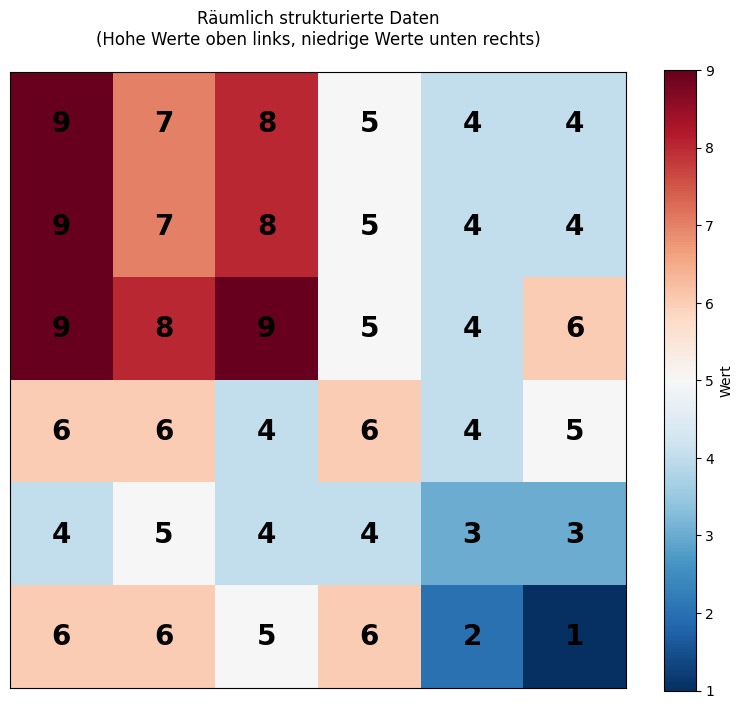

In [181]:
# Visualisierung der Daten
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(data, cmap='RdBu_r', vmin=1, vmax=9)

# Werte in jede Zelle schreiben
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, data[i, j], ha="center", va="center", 
                      color="black", fontsize=20, fontweight='bold')

ax.set_title('Räumlich strukturierte Daten\n(Hohe Werte oben links, niedrige Werte unten rechts)', 
             fontsize=12, pad=20)
plt.colorbar(im, ax=ax, label='Wert')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

## 1.2 Räumliche Gewichtsmatrix (Spatial Weights)

Für die Berechnung von Moran's I benötigen wir eine **Gewichtsmatrix W**, die definiert, welche Zellen Nachbarn sind.

Wir verwenden **Queen-Nachbarschaft** (8 Nachbarn: oben, unten, links, rechts und 4 Diagonalen) und **Reihen-Standardisierung** (jede Zeile summiert sich zu 1).

In [182]:
# Erstelle räumliche Gewichtsmatrix mit PySAL
# Queen-Nachbarschaft für ein 6x6 Gitter
w = weights.lat2W(6, 6, rook=False)
w.transform = 'R'  # Reihen-Standardisierung

print(f"Anzahl der Zellen: {w.n}")
print(f"Durchschnittliche Anzahl Nachbarn: {w.mean_neighbors:.2f}")
print(f"\nBeispiel - Nachbarn von Zelle 0 (oben links):")
print(f"  Nachbarn: {w.neighbors[0]}")
print(f"  Gewichte: {w.weights[0]}")

Anzahl der Zellen: 36
Durchschnittliche Anzahl Nachbarn: 6.11

Beispiel - Nachbarn von Zelle 0 (oben links):
  Nachbarn: [6, 1, 7]
  Gewichte: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## 1.3 Global Moran's I - Formel

Die **Global Moran's I** Statistik misst die räumliche Autokorrelation und ist definiert als:

$$I = \frac{n}{\sum_{i}\sum_{j} w_{ij}} \cdot \frac{\sum_{i}\sum_{j} w_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\sum_{i}(x_i - \bar{x})^2}$$

**Komponenten:**
- $n$: Anzahl der räumlichen Einheiten (hier: 36 Zellen)
- $x_i$: Wert an Position $i$
- $\bar{x}$: Mittelwert aller Werte
- $w_{ij}$: Räumliches Gewicht zwischen Position $i$ und $j$
- $\sum_{i}\sum_{j} w_{ij}$: Summe aller Gewichte $S_0$ (bei Reihen-Standardisierung = $n$)

**Interpretation:**
- $I > 0$: Positive räumliche Autokorrelation (ähnliche Werte sind benachbart)
- $I \approx 0$: Keine räumliche Autokorrelation (zufällige Verteilung)
- $I < 0$: Negative räumliche Autokorrelation (unähnliche Werte sind benachbart)

## 1.4 Aufgabe: Implementieren Sie Moran's I

**Ihre Aufgabe:** Implementieren Sie die Formel Schritt für Schritt.

**Hinweise:**
1. Konvertieren Sie das 2D-Array `data` in einen 1D-Vektor
2. Berechnen Sie den Mittelwert $\bar{x}$
3. Berechnen Sie die Abweichungen $(x_i - \bar{x})$
4. Berechnen Sie den Zähler: $\sum_{i}\sum_{j} w_{ij}(x_i - \bar{x})(x_j - \bar{x})$
5. Berechnen Sie den Nenner: $\sum_{i}(x_i - \bar{x})^2$
6. Berechnen Sie Moran's I

**Tipp:** Sie können über alle Nachbarpaare iterieren mit:
```python
for i in w.neighbors.keys():  # Über alle Zellen iterieren
    for j, wij in zip(w.neighbors[i], w.weights[i]):  # Nachbarn von Zelle i durchlaufen
        # wij ist das Gewicht zwischen i und j
```

In [ ]:
# Schritt 1: Konvertiere 2D Array in 1D Vektor
y = data.flatten()
n = len(y)

# Schritt 2: Berechne Mittelwert
# y_mean = 

# Schritt 3: Berechne Abweichungen vom Mittelwert
# y_dev = 

# Schritt 4: Berechne Zähler (Summe der gewichteten Produkte)

numerator = 0.0
########### TODO: Ihre Implementierung hier ##############
# Iterieren Sie über alle Nachbarpaare

## numerator = 

#####################################################

# Schritt 5: Berechne Nenner (Summe der quadrierten Abweichungen)

denominator = 0.0

########### TODO: Ihre Implementierung hier ##############
# Berechnen Sie die Summe von (y[i] - y_mean)^2

# denominator = 

#####################################################

# Schritt 6: Berechne Moran's I
# Normalisierung nutzt S0 = Summe aller Gewichte

I_manual = 0.0

########### TODO: Ihre Implementierung hier ##############

# Berechne die Summe aller Gewichte
# S0 = 
print(f"Summe aller Gewichte S0: {S0}")
print(f"Anzahl Zellen n: {n}")

# Berechnen Sie I
# I_manual = 

#####################################################

print(f"\nManuell berechnetes Moran's I: {I_manual:.6f}")

Summe aller Gewichte S0: 36.0
Anzahl Zellen n: 36

Manuell berechnetes Moran's I: 0.575034


## 1.5 Vergleich mit PySAL

Jetzt verwenden wir die PySAL-Bibliothek, um Moran's I zu berechnen und mit Ihrer Implementierung zu vergleichen.

In [184]:
# Berechne Moran's I mit PySAL
moran = esda.moran.Moran(y, w)

print("=" * 50)
print("Vergleich der Ergebnisse:")
print("=" * 50)
print(f"Manuell berechnet: {I_manual:.6f}")
print(f"PySAL berechnet:   {moran.I:.6f}")
print(f"Differenz:         {abs(I_manual - moran.I):.10f}")
print("=" * 50)

# Zusätzliche Statistiken von PySAL
print(f"\nZusätzliche Informationen:")
print(f"Erwartungswert E[I]: {moran.EI:.6f}")
print(f"p-Wert:              {moran.p_sim:.6f}")
print(f"z-score:             {moran.z_sim:.6f}")

if moran.p_sim < 0.05:
    print("\n✓ Die räumliche Autokorrelation ist statistisch signifikant (p < 0.05)")
else:
    print("\n✗ Die räumliche Autokorrelation ist nicht statistisch signifikant")

Vergleich der Ergebnisse:
Manuell berechnet: 0.575034
PySAL berechnet:   0.575034
Differenz:         0.0000000000

Zusätzliche Informationen:
Erwartungswert E[I]: -0.028571
p-Wert:              0.001000
z-score:             6.615264

✓ Die räumliche Autokorrelation ist statistisch signifikant (p < 0.05)


## 1.6 Visualisierung: Moran Scatterplot

Der **Moran Scatterplot** zeigt die Beziehung zwischen:
- x-Achse: Standardisierte Werte $(x_i - \bar{x})$
- y-Achse: Räumlich verzögerte Werte (spatial lag) $\sum_j w_{ij}x_j$

Die Steigung der Regressionslinie entspricht Moran's I.

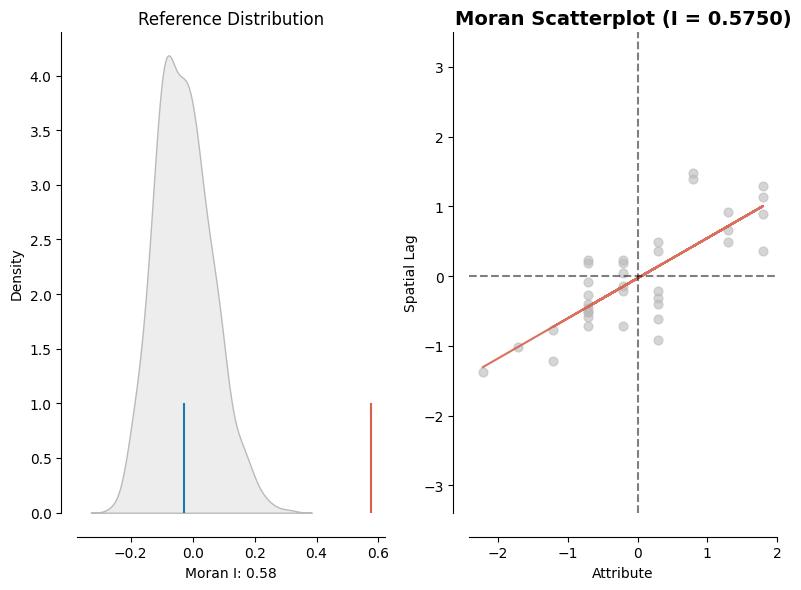

In [185]:
# Moran Scatterplot
plot_moran(moran, zstandard=True, figsize=(8, 6))
plt.title(f"Moran Scatterplot (I = {moran.I:.4f})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.7 Interpretation

**Was bedeutet dieses Ergebnis?**

Ein positiver Moran's I-Wert (I > 0) zeigt **positive räumliche Autokorrelation**:
- Hohe Werte tendieren dazu, neben hohen Werten zu liegen
- Niedrige Werte tendieren dazu, neben niedrigen Werten zu liegen
- Die Daten zeigen eine räumliche Clusterung

In unserem Beispiel:
- Die hohen Werte (8-9) sind in der oberen linken Ecke geclustert
- Die niedrigen Werte (1-3) sind in der unteren rechten Ecke geclustert
- Dies führt zu einem signifikant positiven Moran's I

**Erwartungswert:** Bei zufälliger Verteilung wäre E[I] ≈ -1/(n-1) ≈ -0.029. Unser beobachteter Wert ist deutlich höher!

# Teil 2: Anwendung auf Reale Daten (Brexit)

In diesem Teil wenden wir denselben Analyseablauf wie in Teil 1 auf einen realen räumlichen Datensatz an: die **Brexit-Abstimmungsergebnisse** in Großbritannien (2016).

**Ziel:** Untersuchen Sie, ob es räumliche Muster in der Abstimmung gibt (d.h., sind Regionen mit hohen Leave-Anteilen räumlich geclustert? Zeigen sich räumliche Cluster von Leave- oder Remain-Stimmen?).

**Datensatz:** 
- Geometrien: Verwaltungsbezirke in Großbritannien (Local Authority Districts, ~380 Regionen)
- Variable: Prozentsatz der Leave-Stimmen (% Leave)
- Quelle: UK 2016 Brexit Referendum

**Workflow:**
1. Daten laden und zusammenführen (Geometrien + Abstimmungsergebnisse)
2. Räumliche Gewichte erzeugen (KNN, k=8 nächste Nachbarn)
3. Spatial Lag berechnen und visualisieren (räumlicher Durchschnitt der Nachbarn)
4. Moran's I-Analyse durchführen (räumliche Autokorrelation testen)
5. Ergebnisse interpretieren (räumliche Muster identifizieren)

## 2.1 Daten laden und vorbereiten

In [186]:
brexit_data_path = "brexit/brexit_vote.csv"
ref = pandas.read_csv(brexit_data_path, index_col="Area_Code")
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


In [187]:
lads = geopandas.read_file(
    "brexit/local_authority_districts.geojson"
).set_index("lad16cd")
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.5841, -1.28158 54...."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


## 2.2 Räumliche Daten zusammenführen und visualisieren

Wir verbinden die Abstimmungsdaten mit den Geometrien und projizieren sie in **Web-Mercator** (EPSG:3857), um eine einheitliche räumliche Basis zu schaffen. 
Die Choropleth-Karte zeigt die räumliche Verteilung des Leave-Anteils:
- **Warme Farben** (Gelb): Hohe Leave-Prozentsätze
- **Kalte Farben** (Blau): Niedrige Leave-Prozentsätze

In [188]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)
db.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."


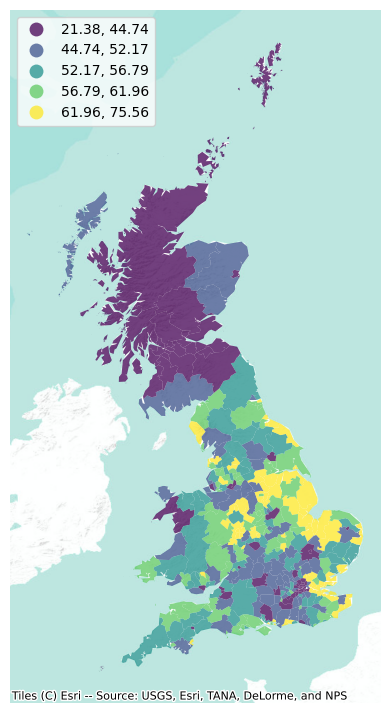

In [189]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

## 2.3 Räumliche Gewichte und KNN-Visualisierung

Mit **KNN (k=8)** definieren wir für jede Region ihre 8 nächsten Nachbarn. Dies ist eine distanzbasierte Nachbarschaftsdefinition, die besonders bei irregulären Geometrien (wie hier: ungleichförmige Verwaltungsbezirke) sinnvoll ist.

Die Visualisierung zeigt:
- **Dunkelrote Punkte:** Zentroide (Mittelpunkte) der Verwaltungsbezirke
- **Blaue Linien:** KNN-Verbindungen (jeder Punkt zu seinen 8 nächsten Nachbarn)

In [190]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

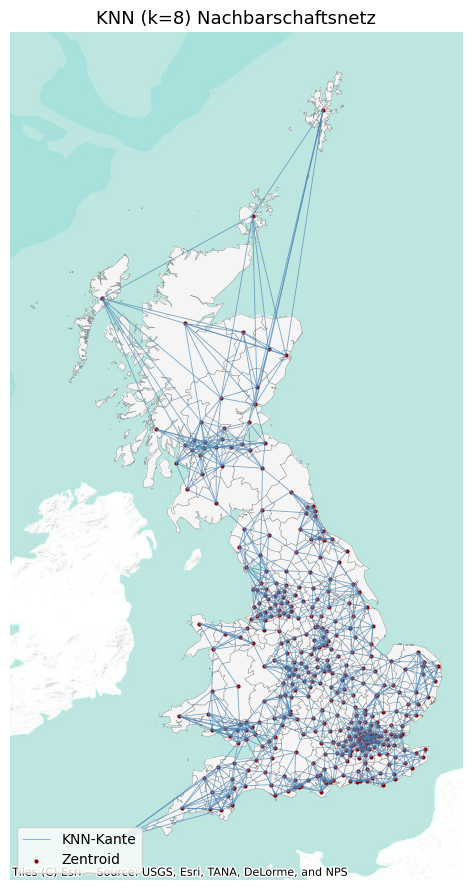

In [191]:
# Visualisiere KNN-Nachbarschaften (k=8)
from shapely.geometry import LineString

# Knotenpunkte (Zentroid der Polygone)
pts = db.geometry.centroid

# Kanten nur einmal aufnehmen (i<j) um doppelte Linien zu vermeiden
edges = []
for i, nbrs in w.neighbors.items():
    for j in nbrs:
        if i < j:
            # i, j können Nicht-Integer-Indizes sein -> loc verwenden
            edges.append(LineString([pts.loc[i], pts.loc[j]]))

lines_gdf = geopandas.GeoDataFrame(geometry=edges, crs=db.crs)

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
lines_gdf.plot(ax=ax, color="steelblue", linewidth=0.6, alpha=0.7, label="KNN-Kante")
db.plot(ax=ax, facecolor="#f5f5f5", edgecolor="#888", linewidth=0.3)
pts.plot(ax=ax, color="darkred", markersize=4, label="Zentroid")
contextily.add_basemap(ax, crs=db.crs, source=contextily.providers.Esri.WorldTerrain)
ax.set_axis_off()
ax.set_title("KNN (k=8) Nachbarschaftsnetz", fontsize=13)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 2.4 Spatial Lag und Moran-Analyse

Der **Spatial Lag** ist der räumlich gewichtete Durchschnitt der Nachbarwerte. Zwei Visualisierungen:
- **Links (% Leave):** Original-Abstimmungsergebnis
- **Rechts (% Leave - Spatial Lag):** Durchschnittlicher Abstimmungsanteil der Nachbarn

Der **Moran-Scatterplot** stellt:
- **x-Achse:** Standardisierte Werte (Abweichung vom Mittelwert)
- **y-Achse:** Standardisierte räumliche Lags (Nachbar-Abweichungen)

Die Steigung der Trendlinie entspricht Moran's I. Ein positiver Wert deutet darauf hin, dass ähnliche Werte räumlich geclustert sind.

In [192]:
db["Pct_Leave_lag"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

In [193]:
db.loc[["E08000012", "S12000019"], ["Pct_Leave", "Pct_Leave_lag"]]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


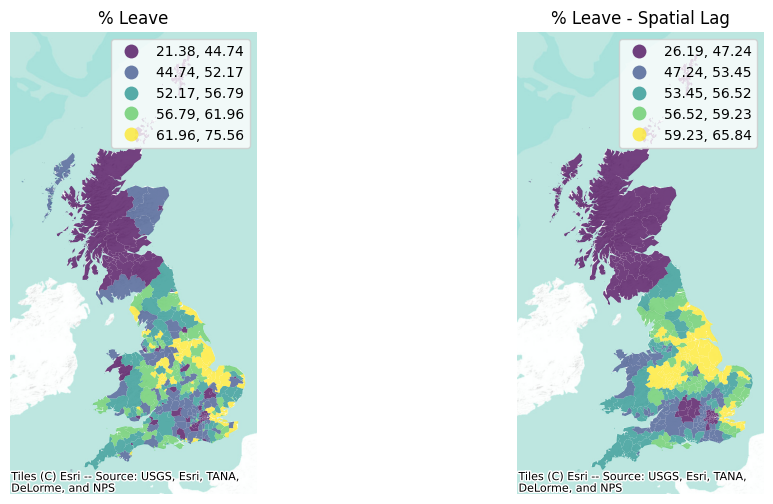

In [194]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="Pct_Leave_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

In [195]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["Pct_Leave_lag_std"] = weights.lag_spatial(
    w, db["Pct_Leave_std"]
)

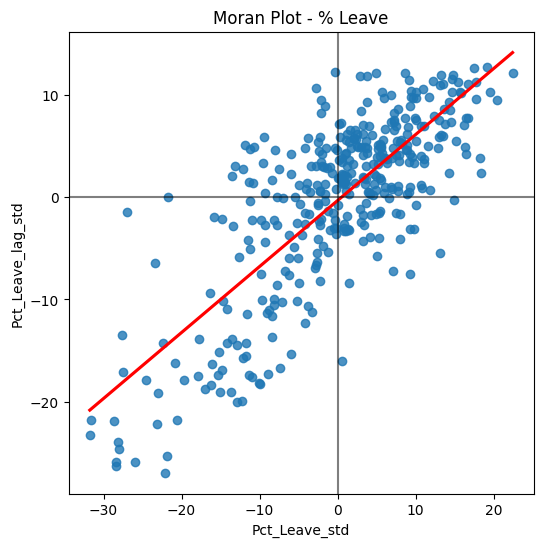

In [196]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

In [ ]:
w.transform = "R"

# Calculate Moran's I using PySAL 
# https://pysal.org/esda/generated/esda.Moran.html

########### TODO: Ihre Implementierung hier ##############
# moran 

In [198]:
moran.I

0.6454521298096587

In [199]:
moran.p_sim

0.001

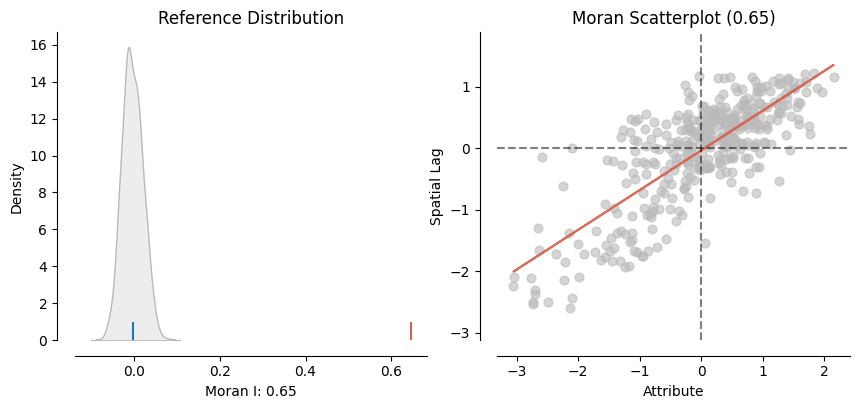

In [200]:
plot_moran(moran);

# Teil 3: Erweiterungen (Alternative Autokorrelationsmaße)

Neben Moran's I gibt es weitere globale Autokorrelationsmaße, die unterschiedliche Aspekte der räumlichen Abhängigkeit messen:

- **Geary's C:** Basiert auf Differenzen zwischen Nachbarwerten. C = 1 bedeutet keine Autokorrelation, C < 1 bedeutet positive Autokorrelation.
- **Getis-Ord G:** Konzentriert sich auf räumliche Konzentration hoher oder niedriger Werte (Hot-/Cold-Spots). Wird hier mit **abstandsbasierten Gewichten** berechnet.

Diese Maße ergänzen Moran's I und ermöglichen eine robustere Interpretation räumlicher Muster.

## 3.1 Geary's C-Statistik

In [ ]:
# Calculate Geary's C using PySAL
# https://pysal.org/esda/generated/esda.Geary.html

########### TODO: Ihre Implementierung hier ##############
# geary 

geary.C

0.4080233215854691

In [202]:
geary.p_sim

0.001

## 3.2 Getis-Ord G (Hot-/Cold-Spot-Analyse)

Die Getis-Ord G-Statistik misst die räumliche Konzentration **hoher oder niedriger Werte**. 
Sie wird mit abstandsbasierten Gewichten berechnet, um lokale räumliche Cluster von extremen Werten zu identifizieren.

Im Brexit-Beispiel:
- Hohe G-Werte deuten auf räumliche Cluster hoher Leave-Prozentsätze hin
- Der p-Wert zeigt die statistische Signifikanz dieses Musters

In [203]:
db_osgb = db.to_crs(epsg=27700)
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

180878.91800926573

In [204]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

In [ ]:
# Calculate Getis Ord G using PySAL
# https://pysal.org/esda/generated/esda.G.html

########### TODO: Ihre Implementierung hier ##############
# gao = 

In [206]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.434 | Pseudo P-value: 0.006



Globale Getis-Ord G Statistik:
  G Statistik: 0.434030
  Erwartungswert E[G]: 0.424177
  Z-Score: 2.805790
  P-Wert: 0.006000

Interpretation: Hohe Werte sind räumlich konzentriert (Hot Spots dominieren)


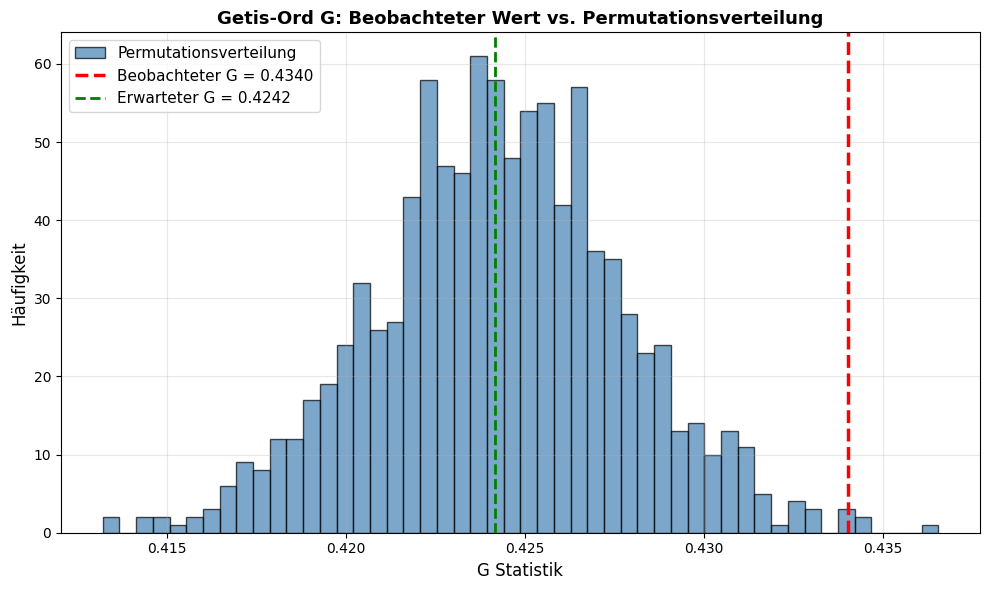


Permutationsverteilung:
  Mittelwert: 0.424292
  Standardabweichung: 0.003471
  Perzentil des beobachteten Wertes: 99.5%


In [207]:
# Visualisierung der Getis-Ord G Ergebnisse

# Globale G-Statistik Zusammenfassung
print(f"\nGlobale Getis-Ord G Statistik:")
print(f"  G Statistik: {gao.G:.6f}")
print(f"  Erwartungswert E[G]: {gao.EG:.6f}")
print(f"  Z-Score: {gao.z_sim:.6f}")
print(f"  P-Wert: {gao.p_sim:.6f}")

# Interpretation
if gao.p_sim < 0.05:
    if gao.G > gao.EG:
        interpretation = "Hohe Werte sind räumlich konzentriert (Hot Spots dominieren)"
    else:
        interpretation = "Niedrige Werte sind räumlich konzentriert (Cold Spots dominieren)"
else:
    interpretation = "Keine signifikante räumliche Konzentration"

print(f"\nInterpretation: {interpretation}")

# Visualisierung: Histogramm der Permutationsverteilung
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(gao.sim, bins=50, alpha=0.7, color='steelblue', edgecolor='black', label='Permutationsverteilung')
ax.axvline(gao.G, color='red', linestyle='--', linewidth=2.5, label=f'Beobachteter G = {gao.G:.4f}')
ax.axvline(gao.EG, color='green', linestyle='--', linewidth=2, label=f'Erwarteter G = {gao.EG:.4f}')
ax.set_xlabel('G Statistik', fontsize=12)
ax.set_ylabel('Häufigkeit', fontsize=12)
ax.set_title('Getis-Ord G: Beobachteter Wert vs. Permutationsverteilung', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Zusammenfassung
print(f"\nPermutationsverteilung:")
print(f"  Mittelwert: {gao.sim.mean():.6f}")
print(f"  Standardabweichung: {gao.sim.std():.6f}")
print(f"  Perzentil des beobachteten Wertes: {(1 - (gao.sim >= gao.G).sum() / len(gao.sim))*100:.1f}%")


# Referenz
- Global Spatial Autocorrelation — Geographic Data Science with Python: https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html (CC BY-NC-ND 4.0)